# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction as well as network fusion;<br/>
4) **Visulization**: network illustration.<br/>

A python package - [STREAM](https://github.com/pinellolab/STREAM) was designed for reconstructing cell trajectory for single cell transcriptomic data. This tutorial guides how to integrate STREAM with pyscnet for gene regulatory network along the cell differential trajectory.


In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=60, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
from pyscnet.Preprocessing import gnetdata
from pyscnet.BuildNet import gne_dockercaller as gdocker
from pyscnet.NetEnrich import graph_toolkit as gt
from pyscnet.Plotting import show_net as sn
from pyscnet.Plotting import geneHeatmap as gh


scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.5 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1


### Data resource
Data was obtained from [Nestorowa, S. et al](https://doi.org/10.1182/blood-2016-05-716480). The cell trajectory was build according to [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true). As STREAM is also built on AnnData structure. It can be directly imported into pyscnet.

In [2]:
#the file is too large
# import _pickle as pk
# with open('data/stream_adata.pk', 'rb') as input:
#     adata = pk.load(input)

import stream as st
adata = st.read('data/stream_adata.pklz')


Working directory is already specified as './result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


As explained in [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true), new attributes including cell pseudotime at different branches are added into **obs** of AnnData. It gives us the hints of checking gene dynamics along peseudotime.

In [12]:
# adata
# st.plot_stream_sc(adata,root='S3',color=['label','Gata1'],
#                   dist_scale=0.3,show_graph=True,show_text=True)

In [4]:
stream_gne = gnetdata.load_from_scanpy(adata)

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), although some tools were designed for estimating gene regulatory relationship from transcriptomic data, only three methods ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were considered as competitive. However, results generated from different algorithms based on different assumptions are inconsistent. Therefore, defining a consensus network from multiple network becomes essential for the downstream analysis.

In [6]:
stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GENIE3', 
                               feature=adata.uns['leaf_markers'][('S1', 'S2')].index,
                              cell_clusterid="('S2', 'S1')", select_by='branch_id_alias')

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='PIDC', 
                               feature=adata.uns['leaf_markers'][('S1', 'S2')].index,
                              cell_clusterid="('S2', 'S1')", select_by='branch_id_alias')

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='CORR', 
                               feature=adata.uns['leaf_markers'][('S1', 'S2')].index,
                              cell_clusterid="('S2', 'S1')", select_by='branch_id_alias')

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GRNBOOST2', 
                               feature=adata.uns['leaf_markers'][('S1', 'S2')].index,
                              cell_clusterid="('S2', 'S1')", select_by='branch_id_alias')

GENIE3_links added into NetAttrs
PIDC_links added into NetAttrs
CORR_links added into NetAttrs
GRNBOOST2_links added into NetAttrs


### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>
3) graph embedding based prediction. <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **Degree, PageRank, Closeness**. Furthermore, gene modules are predicted by applying community detection algorithms.

In [7]:
#find consensus links based on ensemble classification
stream_gne = gt.find_consensus_graph(stream_gne, method='ensemble', threshold=5)

#build graph for consensus links
stream_gne = gdocker.buildnet(stream_gne, key_links='consensus')

there are 108 consensus edges found!
graph added into NetAttrs


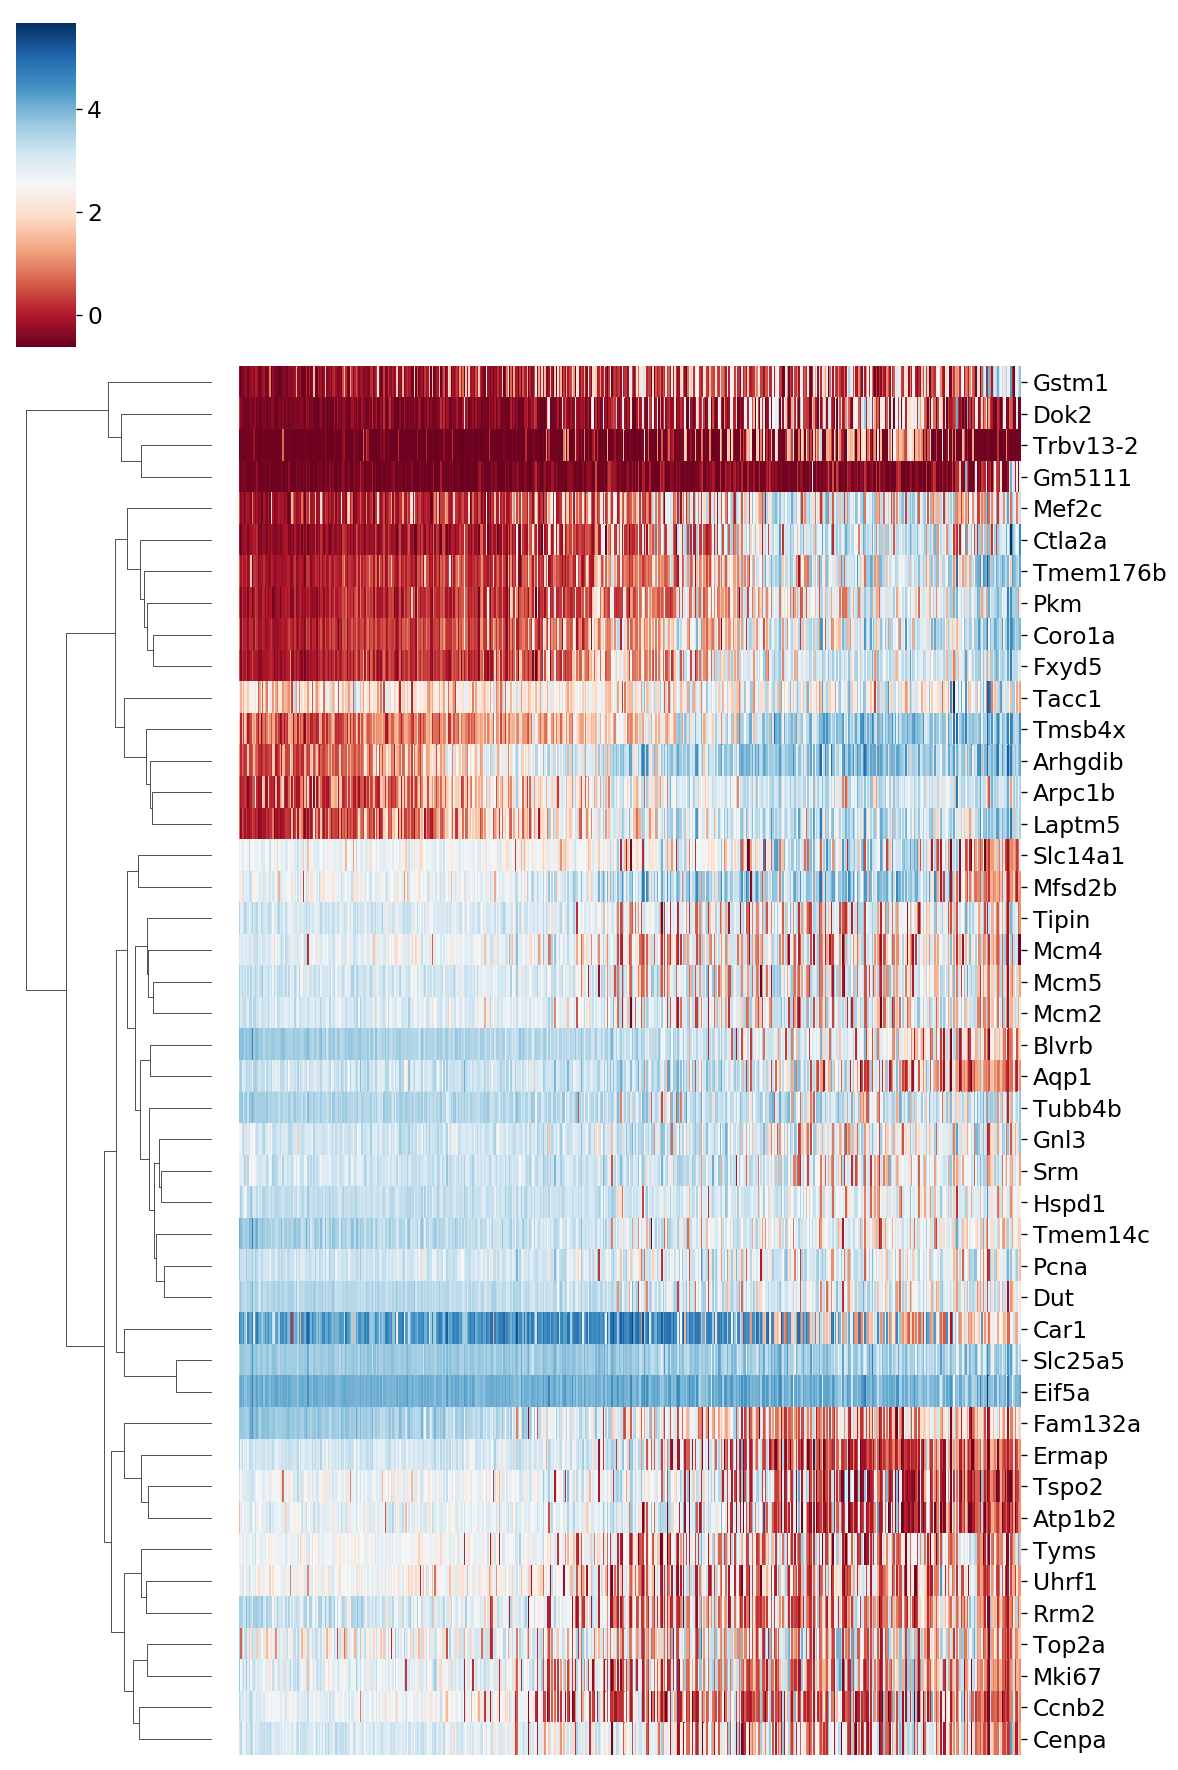

In [8]:
gh.geneHeatmap(stream_gne, gene=set(stream_gne.NetAttrs['consensus'].source),
            cell_clusterid="('S2', 'S1')", select_by='branch_id_alias',
            order_by='S2_pseudotime', col_cluster=False, yticklabels=True, 
            figsize=[10,15], save_as='result/gene_heatmap.pdf')

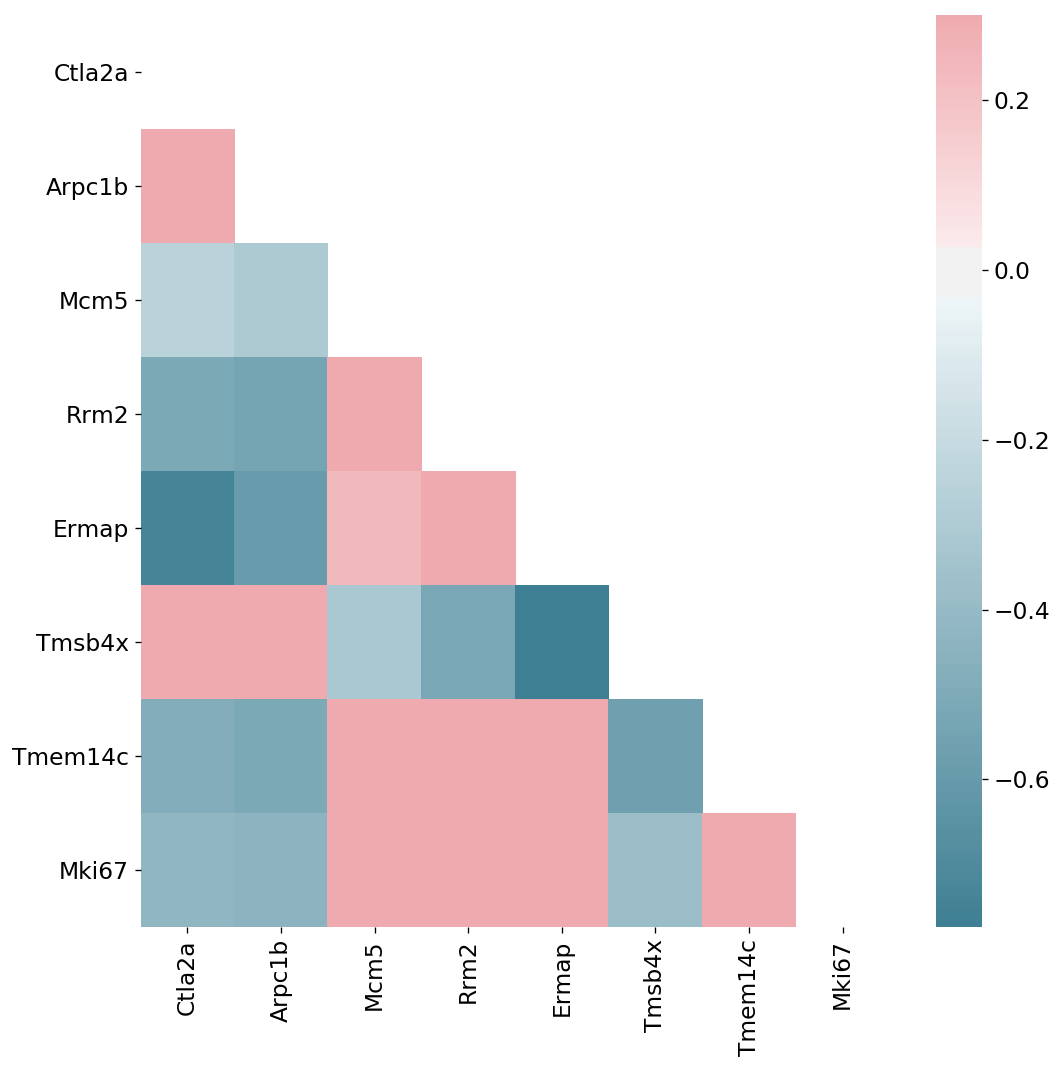

In [9]:
gh.geneCorrelation(stream_gne, gene=set(stream_gne.NetAttrs['consensus'].source[1:10]),
                cell_clusterid="('S2', 'S1')", select_by='branch_id_alias',
                order_by='S2_pseudotime', yticklabels=True, xticklabels=True, 
                save_as='result/gene_correlation.pdf')

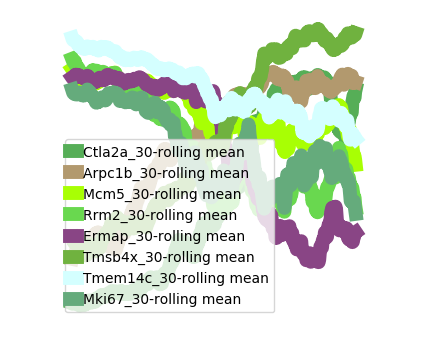

In [10]:
sc.settings.set_figure_params(dpi=50, facecolor='white')
gh.geneDynamic(stream_gne, gene=set(stream_gne.NetAttrs['consensus'].source[1:10]),
                cell_clusterid="('S2', 'S1')", select_by='branch_id_alias', rolling=30,
                order_by='S2_pseudotime')